In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

---
## Regresión Logística Multiclase

Recuerdo: 

El AIC y el BIC son criterios de selección de modelos los cuales pretenden una noción de la complejidad del modelo versus la información que este logra capturar de los datos:

\begin{equation*}

    AIC = 2d - 2log(\hat{L}(D))

\end{equation*}

\begin{equation*}

    BIC = log(N)d - 2log(\hat{L}(D))

\end{equation*}

Teniendo que $d$ es la cantidad de parámetros que tiene el modelo. $\hat{L}(D)$ es la verosimilitud del EMV dado los datos $D$ y $N$ es la cantidad total de datos. 

Notar que ambos criterios penalizan la complejidad del modelo en base a la cantidad de parámetros y buscan la mejor verosimilitud, lo que implica que en ambos criterios nos interesa el modelo que tenga un menor $AIC$ y/o $BIC$

In [31]:
def get_criterions(X, y, clf):

    d = clf.coef_.size + clf.intercept_.size
    print("Parameters:", d)

    log_probas = [ll[y[i]] for i, ll in enumerate(clf.predict_log_proba(X))]
    print("Log-Likelihood:", np.sum(log_probas))

    print("AIC:", 2 * d - 2 * np.sum(log_probas))
    print("BIC:", np.log(len(X)) * d - 2 * np.sum(log_probas))
    

### Ejemplo 1: Iris dataset

In [32]:
from sklearn.datasets import load_iris

data = load_iris()

df = pd.DataFrame(data=data.data, columns=data.feature_names)

df["target"] = data.target
df["names"] = [data.target_names[i] for i in data.target]

df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target   names  
0       0  setosa  
1       0  setosa  
2       0  setosa  
3       0  setosa  
4       0  setosa

- Un poco de ingeniería de características

In [33]:
df["sepal_surface"] = df["sepal length (cm)"] * df["sepal width (cm)"]
df["petal_surface"] = df["petal length (cm)"] * df["petal width (cm)"]

df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target   names  sepal_surface  petal_surface  
0       0  setosa          17.85           0.28  
1       0  setosa          14.70           0.28  
2       0  setosa          15.04           0.26  
3       0  setosa          14.26           0.30  
4       0  setosa          18.00           0.28

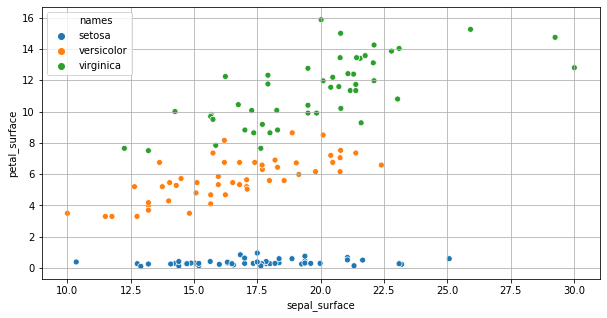

In [34]:
plt.figure(figsize=(10,5))
sns.scatterplot("sepal_surface", "petal_surface", data=df, hue="names")
plt.grid()
plt.show()

- Normalización para evitar problemas de convergencia en el optimizador de la Regresión Logística

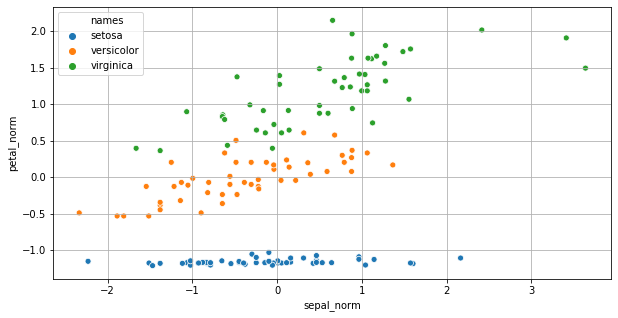

In [35]:
from sklearn.preprocessing import StandardScaler

X = df[["sepal_surface", "petal_surface"]].values
y = df["target"].values

scaler = StandardScaler()

X = scaler.fit_transform(X)

df["sepal_norm"] = X[:, 0]
df["petal_norm"] = X[:, 1]

plt.figure(figsize=(10,5))
sns.scatterplot("sepal_norm", "petal_norm", data=df, hue="names")
plt.grid()
plt.show()

- Crear grilla con todo el espacio

In [36]:
sepals = np.linspace(df["sepal_norm"].min(), df["sepal_norm"].max(), 100)
petals = np.linspace(df["petal_norm"].min(), df["petal_norm"].max(), 100)

# create the mesh based on these arrays
sepals, petals = np.meshgrid(sepals, petals)
sepals, petals = sepals.flatten(), petals.flatten()

df_space = pd.DataFrame({"sepals": sepals, "petals": petals})

- Regresión Logística Lineal

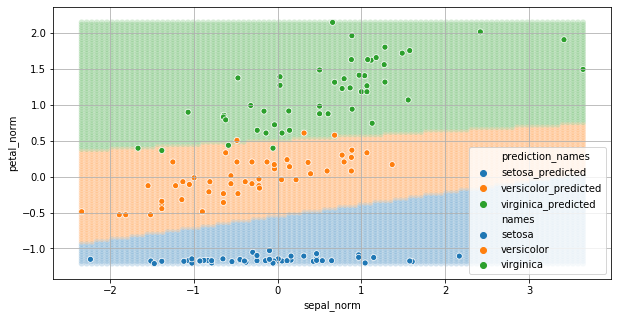

Parameters: 9
Log-Likelihood: -28.179961722681643
AIC: 74.35992344536328
BIC: 101.45564109222958


In [37]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X, y)

df_space["prediction"] = clf.predict(df_space[["sepals", "petals"]].values)
df_space["prediction_names"] = [data.target_names[i] + "_predicted" for i in df_space.prediction.values]

plt.figure(figsize=(10,5))
sns.scatterplot("sepals", "petals", data=df_space, hue="prediction_names", alpha=0.2)
sns.scatterplot("sepal_norm", "petal_norm", data=df, hue="names")
plt.grid()
plt.show()

get_criterions(X, data.target, clf)

- Regresión Logística Polinomial

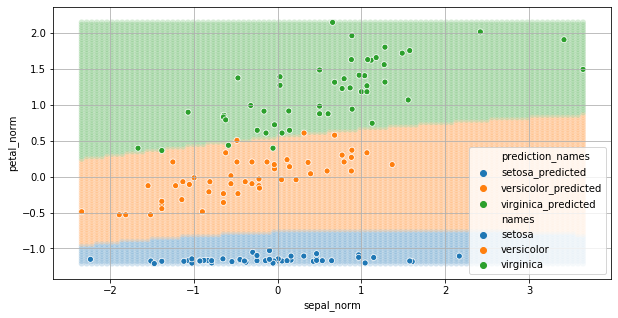

Parameters: 21
Log-Likelihood: -15.928422623849205
AIC: 73.8568452476984
BIC: 137.08018642371977


In [38]:
from sklearn.preprocessing import PolynomialFeatures

poly_grade = 2

X_poly = PolynomialFeatures(poly_grade).fit_transform(X)

clf = LogisticRegression(random_state=0).fit(X_poly, y)

poly_space = PolynomialFeatures(poly_grade).fit_transform(df_space[["sepals", "petals"]].values)

df_space["prediction"] = clf.predict(poly_space)
df_space["prediction_names"] = [data.target_names[i] + "_predicted" for i in df_space.prediction.values]

plt.figure(figsize=(10,5))
sns.scatterplot("sepals", "petals", data=df_space, hue="prediction_names", alpha=0.2)
sns.scatterplot("sepal_norm", "petal_norm", data=df, hue="names")
plt.grid()
plt.show()

get_criterions(X_poly, data.target, clf)

---
### Ejemplo 2: Convenient Dataset

In [39]:
n_data_points = 50

mean1 = [1, -1]
mean2 = [7, 0]

cov = [[1.0, 0.5], [0.5, 1.0]]

np.random.seed(1)

X1 = np.random.multivariate_normal(mean1, cov, n_data_points)
y1 = np.zeros(len(X1), dtype=int)

X2 = np.random.multivariate_normal(mean2, cov, n_data_points)
y2 = np.ones(len(X2), dtype=int)

In [40]:
rad = 6
thk = 2
sep = 1

# Centro del circulo
c =  np.array([-(rad + thk) / 2, -sep / 2])

np.random.seed(1)
# Radio y angulos random
r = np.random.rand(n_data_points) * thk + rad
a = np.random.rand(n_data_points) * np.pi + np.pi

# Pasar a coordenadas cartesianas
p = np.array((r * np.cos(a), r * np.sin(a)))

X3 = np.vstack((p[0] - c[0], p[1] - c[1])).T
y3 = np.ones(len(X3), dtype=int) * 2

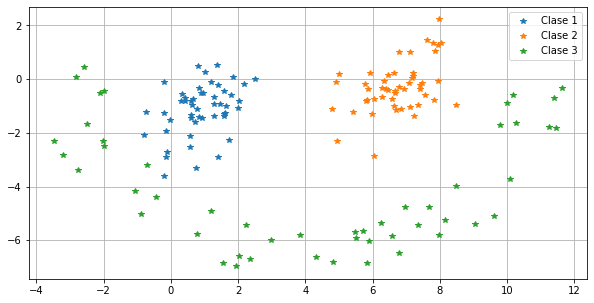

In [41]:
### Unimos los datos
X = np.vstack((X1, X2, X3))
y = np.concatenate((y1, y2, y3))


plt.figure(figsize=(10,5))
plt.plot(X1[:,0],X1[:,1],"*", label = "Clase 1")
plt.plot(X2[:,0],X2[:,1],"*", label = "Clase 2")
plt.plot(X3[:,0],X3[:,1],"*", label = "Clase 3")
plt.legend(), plt.grid()
plt.show()

- Crear grilla con todo el espacio

In [42]:
X_0 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
X_1 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)

# create the mesh based on these arrays
X_0, X_1 = np.meshgrid(X_0, X_1)
X_0, X_1 = X_0.flatten(), X_1.flatten()

X_space = np.vstack((X_0, X_1)).T

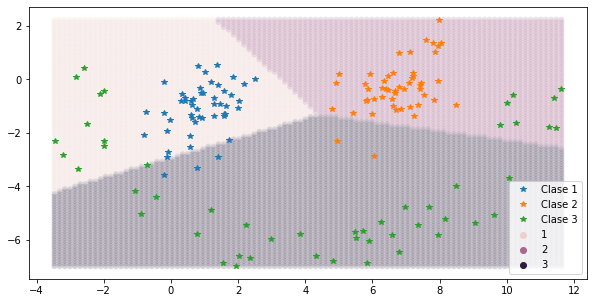

Parameters: 9
Log-Likelihood: -80.1884245916194
AIC: 178.3768491832388
BIC: 205.47256683010508


In [43]:
clf = LogisticRegression(random_state=0).fit(X, y)

predictions = clf.predict(X_space)

plt.figure(figsize=(10,5))
sns.scatterplot(X_space[:, 0], X_space[:, 1], hue=predictions+1, alpha=0.2, legend="full")
plt.plot(X1[:,0],X1[:,1],"*", label = "Clase 1")
plt.plot(X2[:,0],X2[:,1],"*", label = "Clase 2")
plt.plot(X3[:,0],X3[:,1],"*", label = "Clase 3")
plt.legend()
plt.show()

get_criterions(X, y, clf)

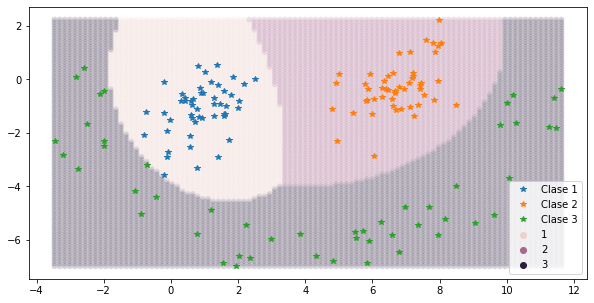

Parameters: 21
Log-Likelihood: -2.7068083071559323
AIC: 47.41361661431186
BIC: 110.63695779033323


In [44]:
poly_grade = 2

X_poly = PolynomialFeatures(poly_grade).fit_transform(X)

clf = LogisticRegression(random_state=0).fit(X_poly, y)

poly_space = PolynomialFeatures(poly_grade).fit_transform(X_space)

predictions = clf.predict(poly_space)

plt.figure(figsize=(10,5))
sns.scatterplot(X_space[:, 0], X_space[:, 1], hue=predictions+1, alpha=0.2, legend="full")
plt.plot(X1[:,0],X1[:,1],"*", label = "Clase 1")
plt.plot(X2[:,0],X2[:,1],"*", label = "Clase 2")
plt.plot(X3[:,0],X3[:,1],"*", label = "Clase 3")
plt.legend()
plt.show()

get_criterions(X_poly, y, clf)

---
## Perceptron

In [181]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron

def kfold_crossvalidation(dataset, k, learning_rate, epochs):

    np.random.seed(1)
    shuffled_data = np.random.permutation(dataset.to_numpy())

    n_test = len(dataset) // k

    scaler = StandardScaler()

    accuracy = 0

    for i in range(k):

        index = [i * n_test, (i + 1) * n_test]
        
        train1, test, train2 = np.split(shuffled_data, index, axis=0)
        train = np.concatenate([train1, train2], axis=0)

        X_train = train[:, :-1]   # instances
        X_train = scaler.fit_transform(X_train)
        y_train = train[:, -1]  # labels
        #y_train = label_to_onehot(y_train, classes)

        X_test = test[:, :-1]    # instances
        X_test = scaler.fit_transform(X_test)
        y_test = test[:, -1]  # labels


        perceptron = Perceptron(eta0 = learning_rate, max_iter = epochs)
        perceptron.fit(X_train, y_train)
        y_predict = perceptron.predict(X_test)

        accuracy += accuracy_score(y_test, y_predict)

    return accuracy/k

In [188]:
from sklearn.datasets import load_digits as dataset

data = dataset()

df = pd.DataFrame(data=data.data, columns=data.feature_names)

df["target"] = data.target

print(df)

      pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
0           0.0        0.0        5.0       13.0        9.0        1.0   
1           0.0        0.0        0.0       12.0       13.0        5.0   
2           0.0        0.0        0.0        4.0       15.0       12.0   
3           0.0        0.0        7.0       15.0       13.0        1.0   
4           0.0        0.0        0.0        1.0       11.0        0.0   
...         ...        ...        ...        ...        ...        ...   
1792        0.0        0.0        4.0       10.0       13.0        6.0   
1793        0.0        0.0        6.0       16.0       13.0       11.0   
1794        0.0        0.0        1.0       11.0       15.0        1.0   
1795        0.0        0.0        2.0       10.0        7.0        0.0   
1796        0.0        0.0       10.0       14.0        8.0        1.0   

      pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_7  pixel_7_0  \
0           0.0        0.0      

In [189]:
learning_rates = [10**i for i in range(-5, 2)]

different_epochs = [10, 20, 100]

k = 4 # 25% en validacion

results = np.empty((len(different_epochs), len(learning_rates)))

for i, epochs in enumerate(different_epochs):

    for j, lr in enumerate(learning_rates):

        results[i, j] = kfold_crossvalidation(df, k, lr, epochs)

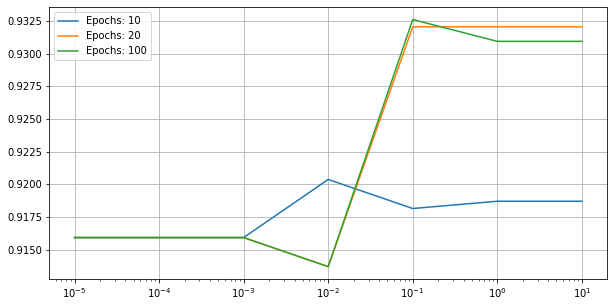

In [190]:
plt.figure(figsize=(10, 5))
plt.xscale('log')

for i, epochs in enumerate(different_epochs):
    plt.plot(learning_rates, results[i], label=f"Epochs: {epochs}")

plt.grid(), plt.legend()
plt.show()